In [ ]:
# New .py for pure lasagne
# This is Convolutional Autoencoder using Theano and Lasagne wrapper. 

import os 
import sys 
import h5py 
import time

import numpy as np
sys.path.insert(0,'/global/common/cori/software/theano/0.8.2/lib/python2.7/site-packages/')
import theano
import theano.tensor as T
sys.path.insert(0,'/global/common/cori/software/lasagne/0.1/lib/python2.7/site-packages/')
import lasagne

from lasagne.layers import InputLayer, DenseLayer
from lasagne.layers import Conv2DLayer, Deconv2DLayer
from lasagne.layers import MaxPool2DLayer, Upscale2DLayer
from lasagne.layers import ReshapeLayer 

from lasagne.objectives import squared_error

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt


# ################## Load the dataset ################################
# Here the dataset is Cosmological maps with Image size 128x128 with total 
# sample size 64,000. The raw training data is unpacked from a h5py file 
# The data is then split into Training and Validation sets. Remember this
# is Unsupervised Learning so there are no Labels. 

def load_data():

    # Load the dataset
    
    # Here we give different data sets for the autoencoders
    dataurl = '/global/homes/s/ssingh79/data/'
    #hdf5file = 'conv_z02.h5'
    hdf5file = 'train_data_64k.h5'
    filepath = os.path.join(dataurl, hdf5file)
    
    print("Calling ", hdf5file, "......")
    # Call the load_data method to get back the Final training set. 
    dataset = filepath
    
    # Change this to create the Sample size!!!
    sample_size = 50
    
    with h5py.File(dataset,'r') as hf:
        #train_set = hf['X_train'][0:1000,0:65536]
        train_set = hf['X_train'][0:sample_size,:]
        print("Printing Train set ", train_set)
        print("X_train shape ", train_set.shape)
   
    #Specify the training set percent. 
    split_percent = 0.90

    #################### Preprocessing ###############################
    # We first pass the train_set to reshape_data(), then training data is split into training set and validation set & then both the data sets are normalized. The reshape funtion then reshapes the falttened images into 2D images of (128,128) which is our final dataset that goes as input to the Network! :)
    
    def train_valid_split(train_set, sample_size, split_percent):
        #Create Training set and Validation set: Randomly Sampling the images by %. 
        X = np.random.choice(sample_size, sample_size, replace=False)
          
        #Get the random indices of images.  
        train_split = sample_size*split_percent
        train_index = X[0:train_split]
        valid_index = X[train_split:sample_size]

        # Training set
        train_x = train_set[train_index[:], : ]
        print("Training Set : ", train_x)
        print(train_x.shape) 

        #Validation set
        valid_x = train_set[valid_index[:], : ]
        print("Validation Set : ", valid_x)
        print(valid_x.shape)
        
        #visualize_raw_data(train_x)
        #visualize_raw_data(valid_x)
        
        return train_x, valid_x 
    
    def normalize(train_x, valid_x):
        # Normalization of dataset goes here : 
        X_norm = np.linalg.norm(train_x, axis=0)
        train_x = train_x/X_norm[np.newaxis,:]
        valid_x = valid_x/X_norm[np.newaxis,:]
        print("Normalized Training data : ", train_x)
        print("Mean : ", np.mean( train_x))
        print("min : ", np.min(train_x))
        print("max : ", np.max(train_x))
        print("Valid set min : ", np.min(valid_x))
        print("Valid set max : ", np.max(valid_x))
        
        return train_x, valid_x 
    
    def reshape_data(train_set):
        # Call the train_valid_split creating random samples. 
        train_x, valid_x = train_valid_split(train_set, sample_size, split_percent)
        
        # Normalize the training data and validation data. 
        train_x, valid_x = normalize(train_x, valid_x) 
        
        # Here goes the code to Reshape to 2D images. Return the 2D images as 
        # X_train and x_validation after reshaping. 
        train_x = train_x.reshape(-1,1,128,128)
        print("After Reshaping, training data : ", train_x.shape)
        valid_x = valid_x.reshape(-1,1,128,128)
        print("After Reshaping, validation data : ", valid_x.shape)
        
        # Visualize the normlaized data. 
        #visualize_normalized_data(train_x)
        
        return train_x, valid_x
    
    def visualize_raw_data(train_x):
        # Save image as png to Output_files folder. 
        image = np.reshape(train_x[0,:],(128,128))
        print("Saving Training image .............")
        plt.imsave('/global/homes/s/ssingh79/Output_files/training_x1.png', image)
        
        # Save histogram of pixels in an image. 
        fig = plt.figure(figsize=(5, 4))
        ax = fig.add_subplot(1,1,1) # one row, one column, first plot
        ax.hist((image), bins=20, color= 'blue')
        ax.set_title("Raw image pixels Histogram Plot")
        ax.set_xlabel("Pixel values")
        ax.set_ylabel("Frequency")
        print("Saving histogram of raw image.....")
        fig.savefig("/global/homes/s/ssingh79/Output_files/raw_hist.png")
        
        
    def visualize_normalized_data(train_x):
        # Visualize the normalized images. 
        print("Saving normalized training image ...........")
        plt.imsave('/global/homes/s/ssingh79/Output_files/normalized_x1.png', train_x[0])
        
        # Save histograms of pixels in the normalized image. 
        fig = plt.figure(figsize=(5, 4))
        ax = fig.add_subplot(1,1,1) # one row, one column, first plot
        ax.hist((train_x[0]), bins=20)
        ax.set_title("Normalized image pixels Histogram Plot")
        ax.set_xlabel("Pixel values")
        ax.set_ylabel("Frequency")
        print("Saving histogram of normalized image.....")
        fig.savefig("/global/homes/s/ssingh79/Output_files/norm_hist.png")
    
    # Final dataset is here after all the preprocessing. 
    train_x, valid_x = reshape_data(train_set)
    
    print("Final Training data", train_x)
    print(train_x.shape)
    print("Final Validation data", valid_x)
    print(valid_x.shape)
    
    return train_x, valid_x  

# ##################### Build the neural network model #######################
# This script supports three types of models. For each one, we define a
# function that takes a Theano variable representing the input and returns
# the output layer of a neural network model built in Lasagne.

def build_conv_ae(input_var=None):
    
    # We will be building a Convolutional Autoencoder with multiple Conv2D and
    # Deconv2D layers. The Lasagne layers are packed step by step where output
    # of each layer is an input of the next layer. The function returns a 
    # network ready to be trained. 
    
    conv_num_filter = 64
    filter_size = 7
    hidden_units = 52*52
    encode_size = 800
    
    # Input layer, specifying the expected input shape of the network
    # (unspecified batchsize, 1 channel, 128 rows and 128 columns) and
    # linking it to the given Theano variable `input_var`, if any:
    l_in = lasagne.layers.InputLayer(shape=(None, 1, 128, 128),
                                     input_var=input_var)
    
    #Formula : dim = {(image_size - filter_size + 2*padding)/stride} + 1 
    #Formula by convention : alpha =  {(i - k + 2*p)/s} + 1  

    # Add First Convolution2D layer -- (64, 122, 122)
    l_conv_first = lasagne.layers.Conv2DLayer(l_in, 
                                              num_filters=conv_num_filter, 
                                              filter_size=filter_size, 
                                              stride=(1,1), 
                                              pad=0)
    
    # Add Second Convolution2D Layer -- (64, 116, 116)
    l_conv_second = lasagne.layers.Conv2DLayer(l_conv_first, 
                                               num_filters=conv_num_filter, 
                                               filter_size=filter_size,
                                               stride=(1,1),
                                               pad=0)
    # Add max pooling layer -- (64, 58, 58)
    l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv_second,
                                          pool_size=2)
    
    
    # Add Third Convolution2D Layer -- (64, 110, 110) // (64, 52, 52)
    l_conv_third = lasagne.layers.Conv2DLayer(l_pool1, 
                                               num_filters=conv_num_filter, 
                                               filter_size=filter_size,
                                               stride=(1,1),
                                               pad=0)
    
    # Flattened Hidden Layer in the middle
    # Use Reshape layer to flatten the images. 
    #l_reshape_conv = lasagne.layers.ReshapeLayer()
    
    # Add a fully-connected layer of ###### units, using the non-linear tanh, and
    # initializing weights with Glorot's scheme (which is the default anyway):
    
    l_hid1 = lasagne.layers.DenseLayer(l_conv_third, 
                                       num_units=hidden_units, 
                                       nonlinearity=lasagne.nonlinearities.tanh, 
                                       W=lasagne.init.GlorotUniform()) 
    
    # We'll now add dropout of 50%:
    #l_hid1_drop = lasagne.layers.DropoutLayer(l_hid1, p=0.2) 
        
    # Encode layer: 
    #encode = lasagne.layers.DenseLayer(l_hid1_drop,
    #                                  num_units=encode_size,
    #                                  nonlinearity = lasagne.nonlinearities.tanh,
    #                                  W = lasagne.init.GlorotUniform())
    
    # Decoded fully connected layer. The dimensions are same as the previous
    # dense layer before encoding. 
    #l_hid2 = lasagne.layers.DenseLayer(encode,
    #                                  num_units=hidden_units,
    #                                  nonlinearity = lasagne.nonlinearities.tanh)
    
    # Reshape Layer to convert the Fully connected layer into 2D images again.
    l_reshape_deconv = lasagne.layers.ReshapeLayer(l_hid1,
                                                   shape=(([0], conv_num_filter, 52, 52))
                                                  )
    # Damn! This is so hard-coded!!!
    
    
    # Here we start Transposing the Convolutional layers, also called Deconvolution.
    # We will be using Lasagne's Deconvolution2D layer. 
    # Add the first Deconv layer -- (64, 110, 110) 
    l_deconv_first = lasagne.layers.Deconv2DLayer(l_reshape_deconv,
                                                num_filters= conv_num_filter,
                                                filter_size = filter_size,
                                                stride = (1,1),
                                                pad=0
                                                 )
    
    # Unpool layer one 
    l_unpool1 = lasagne.layers.Upscale2DLayer(l_deconv_first,
                                             scale_factor=2)
    
    # Add the Second Deconv layer -- (64, 116, 116)
    l_deconv_second = lasagne.layers.Deconv2DLayer(l_unpool1,
                                                num_filters= conv_num_filter,
                                                filter_size = filter_size,
                                                stride = (1,1),
                                                pad=0
                                                 )
    
    # Add the Third Deconv layer -- (64, 122, 122)
    l_deconv_third = lasagne.layers.Deconv2DLayer(l_deconv_second,
                                                num_filters= conv_num_filter,
                                                filter_size = filter_size,
                                                stride = (1,1),
                                                pad=0
                                                )
    
    return network
    
    
    
# ############################# Batch iterator ###############################
# This is just a simple helper function iterating over training data in
# mini-batches of a particular size, optionally in random order. It assumes
# data is available as numpy arrays. For big datasets, you could load numpy
# arrays as memory-mapped files (np.load(..., mmap_mode='r')), or write your
# own custom data iteration function. For small datasets, you can also copy
# them to GPU at once for slightly improved performance. This would involve
# several changes in the main program, though, and is not demonstrated here.
# Notice that this function returns only mini-batches of size `batchsize`.
# If the size of the data is not a multiple of `batchsize`, it will not
# return the last (remaining) mini-batch.

def iterate_minibatches(inputs, batchsize, shuffle=False):
    #assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

        
# ############################## Main program ################################
# Everything else will be handled in our main program now. We could pull out
# more functions to better separate the code, but it wouldn't make it any
# easier to read.

def main(num_epochs = 500):
    # Load the dataset
    print("Loading data...")
    X_train, X_valid = load_data()
    
    # Prepare Theano variables for inputs
    input_var = T.tensor4('inputs')
    target_var = T.tensor4('targets')
    
    # Create neural network model 
    print("Building model and compiling functions...")
    network = build_conv_ae(input_var)
    
    # Create a loss expression for training, i.e., a scalar objective we want
    # to minimize (for our multi-class problem, it is the cross-entropy loss):
    prediction = lasagne.layers.get_output(network)
    loss = lasagne.objectives.squared_error(prediction, target_var)
    loss = loss.mean()
    
    # We could add some weight decay as well here, see lasagne.regularization.
    
    
    # Create update expressions for training, i.e., how to modify the
    # parameters at each training step. Here, we'll use Stochastic Gradient
    # Descent (SGD) with Nesterov momentum, but Lasagne offers plenty more.
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
            loss, params, learning_rate=0.01, momentum=0.6)
    
    # Compile a function performing a training step on a mini-batch (by giving
    # the updates dictionary) and returning the corresponding training loss:
    train_fn = theano.function([input_var, target_var], loss, updates=updates)
    
    # Create a theano funtion to get the prediction. 
    predict_fn = theano.function([input_var], prediction)
    du 
    #*****You may have to write multiple theano function to get the Prediction per se
    
    
    # Finally, launch the training loop.
    print("Starting training...")
    # Create array to append cost. 
    cost_plot = []
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, 500, shuffle=True):
            inputs = batch
            train_err += train_fn(inputs, inputs)
            train_batches += 1
    
        
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        
        cost_plot.append(train_err/train_batches)
        
    
    ############## Visualization code ########################
    
    # Learning curve.     
    plt.plot(cost_plot)
    
    pred_images = predict_fn(x_test)
    
    # Reconstruction of images
    print("Saving reconstructed images. ") 
    plt.imsave('./Output_files/ae_reconstruct.png', pred_images[0]) 
    
    
    
main(500)
#load_data()
        

Loading data...
Calling  train_data_64k.h5 ......
Printing Train set  [[-0.01032324  0.00679525  0.0022744  ..., -0.00186596 -0.00139782
  -0.00295408]
 [ 0.03064897  0.00953815  0.03919139 ..., -0.04416131 -0.01501628
  -0.03169146]
 [-0.00054488  0.03779386  0.03071115 ...,  0.03494589 -0.00192948
  -0.01491482]
 ..., 
 [ 0.02127587 -0.02351783 -0.03983395 ..., -0.01969949  0.00536605
   0.00555836]
 [ 0.00138356 -0.02003955 -0.03214408 ...,  0.02426279 -0.00411993
   0.04718859]
 [-0.01484704 -0.03174254 -0.02190411 ..., -0.00429437  0.00678311
   0.01002537]]
X_train shape  (50, 16384)
Training Set :  [[-0.00054488  0.03779386  0.03071115 ...,  0.03494589 -0.00192948
  -0.01491482]
 [ 0.05735752  0.08445425  0.05085959 ...,  0.01728519 -0.01601126
  -0.03631986]
 [ 0.00774886 -0.00895657  0.0008431  ...,  0.01229991  0.02178941
   0.00328053]
 ..., 
 [-0.01484704 -0.03174254 -0.02190411 ..., -0.00429437  0.00678311
   0.01002537]
 [-0.0322797  -0.02684812 -0.02796426 ..., -0.041189

/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:69: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:70: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
plt.imshow 
plt.imsave 
plt.plot 
plt.savefig 

(50, 1, 16, 16)
(1, 16, 16)


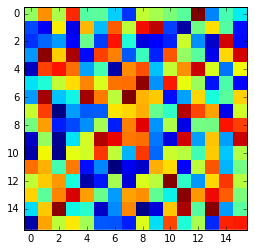

In [1]:
import numpy as np
from matplotlib import pyplot as plt

X = np.random.random((50, 16*16))
#for i in range(0, 50):
X = X.reshape(-1,1,16,16)
print(X.shape)
#print(X)

print(X[1].shape)

%matplotlib inline
plt.imshow(X[0][0], interpolation = 'None')
